In [143]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
import sys
sys.path.append("..")
import os
import shutil
from utils.model import Net_mask
#from utils.data import Data
#from scripts.parameters import get_parameters, get_parameters_1
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [145]:
n_data = 1
n_param = 10
sigma2_data = 1
data_mean = torch.zeros(n_param)
data_covariance = torch.eye(n_param)*sigma2_data

torch.manual_seed(0)
n_data_points = 6
n_points_max = 6

all_points = torch.zeros(100, 20)
all_solutions = torch.zeros(100, 10)

for i in range(n_points_max):
    for j in range(n_data_points):
        torch.manual_seed(f'{i+1}{j}')
        tensor_data = torch.zeros(n_data, 2*n_param)
        tensor_d_sample =  MultivariateNormal(loc=data_mean, covariance_matrix=data_covariance).sample(sample_shape=(n_data,))
        #tensor_n_masked = torch.randint(n_param, (n_data,))
        tensor_n_masked = torch.Tensor([i+1])
        #print(tensor_n_masked)
        tensor_masks = torch.rand(n_data, n_param).argsort(dim=1)
        tensor_masks = (tensor_masks < tensor_n_masked.unsqueeze(1))*1
        tensor_data[:,:n_param] = tensor_d_sample*tensor_masks
        tensor_data[:,n_param:] = tensor_masks
        all_points[int(f'{i+1}{j}'),:] = tensor_data
        #if i==4 and j==3:
        #    print(tensor_data)
        #torch.save(tensor_data, f'../data/test_observations/{i+1}_{j}.pt')
#torch.save(all_points, f'../data/test_observations/all_test_observations.pt')

In [146]:
vu_list = [0.1, 1, 10, 100, 10000]

tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m = torch.mm(torch.t(tensor_D), tensor_D) 
n_param = tensor_D.size(dim=0)
#inversion_scaling = 1./vu
#tensor_Q_m_modified = tensor_Q_m + torch.ones(n_param, n_param)*inversion_scaling
#tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*inversion_scaling

#tensor_eval = torch.zeros(n_data, 2*n_param)

sigma2 = 0.01
tensor_mu_m = torch.zeros(n_param)
#tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
tensor_Sigma_eps = torch.eye(n_param)*sigma2
tensor_mu_eps = tensor_mu_m 

#all_solutions = torch.zeros(100, 10)

sol = torch.zeros(len(vu_list), 10)

for idx_, vu in enumerate(vu_list):

    #vu = 10000
    inversion_scaling = 1./vu
    tensor_Q_m_modified = tensor_Q_m + torch.ones(n_param, n_param)*inversion_scaling
    #tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*inversion_scaling
    #tensor_Q_m_modified = tensor_Q_m
    tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)

    input_tensor = all_points[31,:]
    d = input_tensor[:n_param]
    mask = input_tensor[n_param:]
    location = torch.where(mask > 0.5)
    d = d[location]
    n_data = len(d)
    G = torch.zeros(n_data, n_param)
    for idx, elem in enumerate(location[0]):
        G[idx, elem] = 1
    Sigma_eps = torch.matmul(G, torch.matmul(tensor_Sigma_eps, torch.t(G)))
    mu_eps = torch.matmul(G, tensor_mu_eps)

    #matrix calculations
    Sigma_mm = tensor_Sigma_m
    Sigma_dm = torch.matmul(G,Sigma_mm)
    Sigma_md = torch.matmul(Sigma_mm, torch.t(G))
    Sigma_dd = torch.matmul(G, torch.matmul(Sigma_mm, torch.t(G))) + Sigma_eps
    Sigma_dd_inv = torch.inverse(Sigma_dd)
    mu_m_d = tensor_mu_m + torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv),(d-mu_eps))
    Sigma_m_d = Sigma_mm - torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv), Sigma_dm)
    all_solutions[int(f'{i+1}{j}'),:] = mu_m_d
    sol[idx_] = mu_m_d
#torch.save(all_solutions, f'../data/test_observations/all_test_solutions.pt')

In [147]:
sol

tensor([[-1.6393e-01, -5.5109e-01, -5.9440e-01, -2.9386e-01, -4.7625e-01,
         -3.1479e-01,  1.9052e-01,  1.0397e+00,  6.3145e-01,  5.6708e-01],
        [-1.2388e-01, -4.9791e-01, -5.5422e-01, -2.9282e-01, -4.3607e-01,
         -2.6160e-01,  2.3057e-01,  1.0405e+00,  6.4531e-01,  5.6786e-01],
        [ 8.6396e-02, -2.1869e-01, -3.4326e-01, -2.8734e-01, -2.2511e-01,
          1.7613e-02,  4.4085e-01,  1.0446e+00,  7.1803e-01,  5.7198e-01],
        [ 3.1101e-01,  7.9574e-02, -1.1792e-01, -2.8148e-01,  2.2736e-04,
          3.1588e-01,  6.6546e-01,  1.0490e+00,  7.9572e-01,  5.7638e-01],
        [ 3.6243e-01,  1.4787e-01, -6.6321e-02, -2.8015e-01,  5.1822e-02,
          3.8416e-01,  7.1689e-01,  1.0500e+00,  8.1350e-01,  5.7739e-01]])

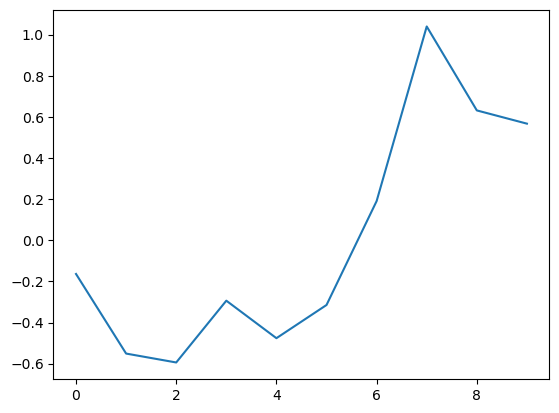

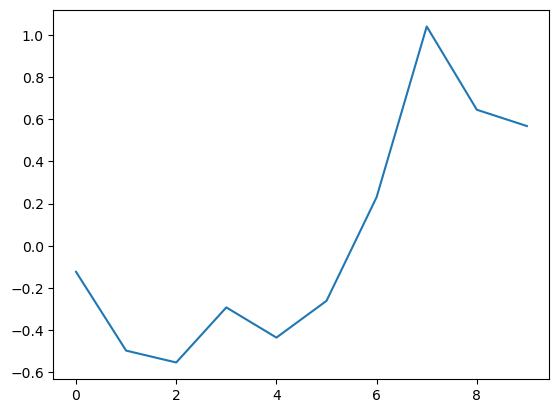

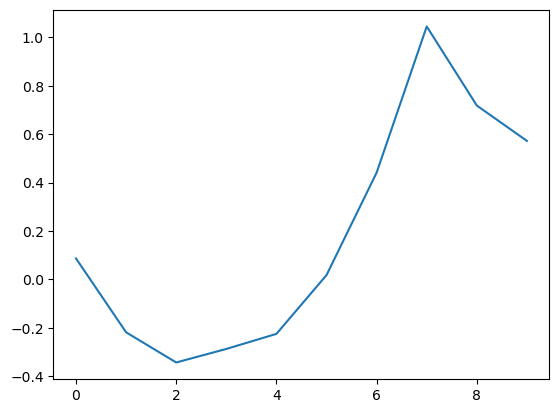

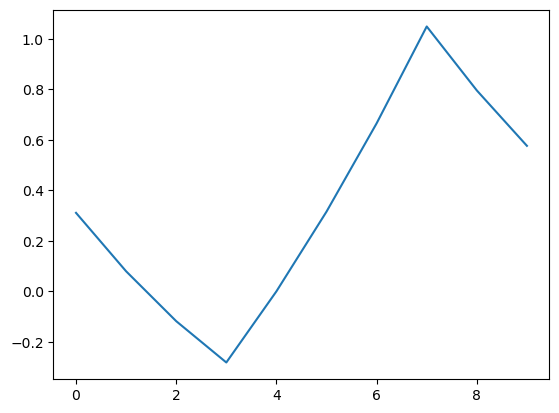

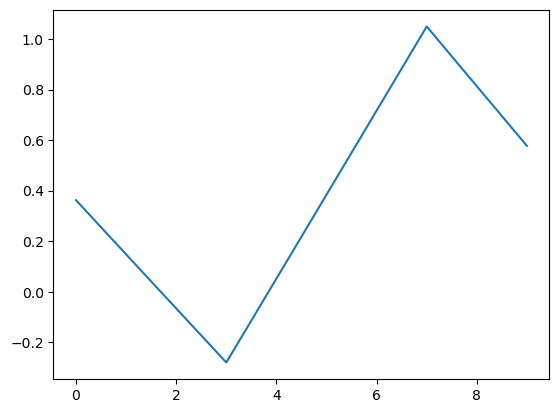

In [148]:
for i in range(5):
    plt.figure()
    plt.plot(range(10), sol[i])

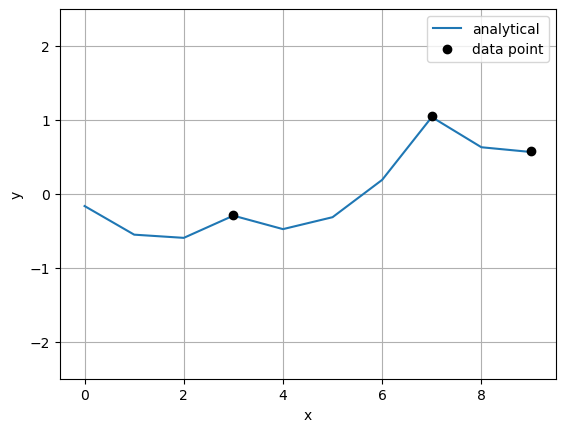

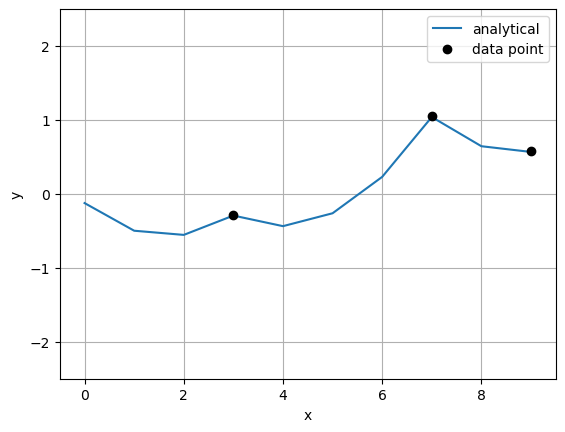

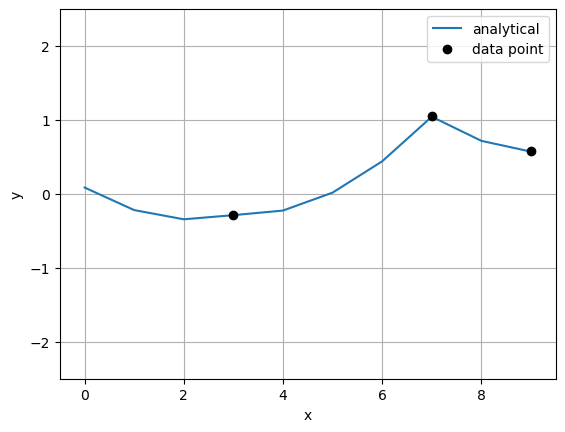

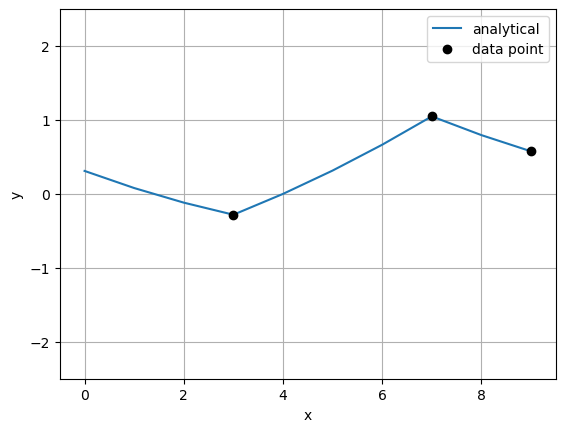

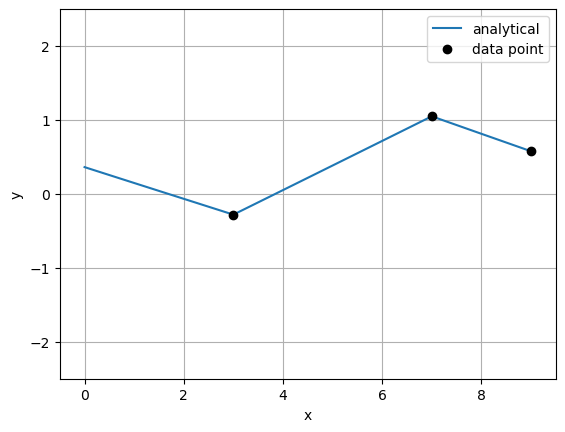

In [149]:
#j = 0
for idx_, vu in enumerate(vu_list):
    input_tensor = all_points[31,:]
    #ind = int(f'{num_points}{j}')
    y = input_tensor[:10]
    mask = input_tensor[10:]
    mask_bool = mask > 0.5
    points = torch.where(mask_bool)[0]
    values = y[mask_bool]

    #test_obs = test_obses[ind]
    #out = model(test_obs)

    plt.figure()
    #plt.title(f'analytical, {num_points} data points')
    #if num_points == 1:
    #    plt.title(f'analytical, {num_points} data point')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(range(10), sol[idx_])
    plt.plot(points, values, 'ko')
    #plt.plot(range(10), out.detach().numpy())
    plt.legend(['analytical', 'data point'])
    #plt.legend(['data points', 'analytical', 'ML-inf'])
    plt.grid()
    plt.axis([-0.5, 9.5, -2.5, 2.5])
    #plt.savefig(f'../figures/plot_analytical/plot_analytical_{num_points}.png')

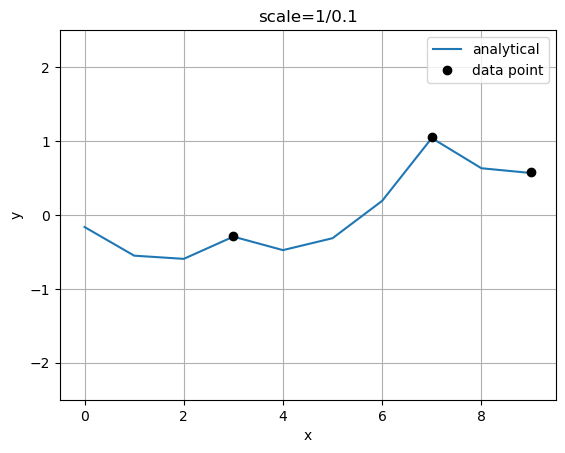

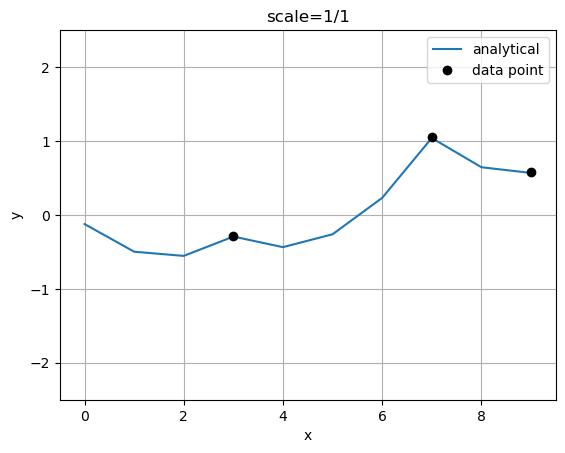

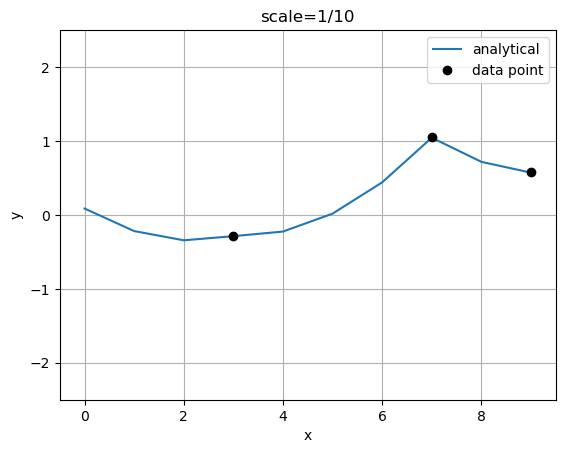

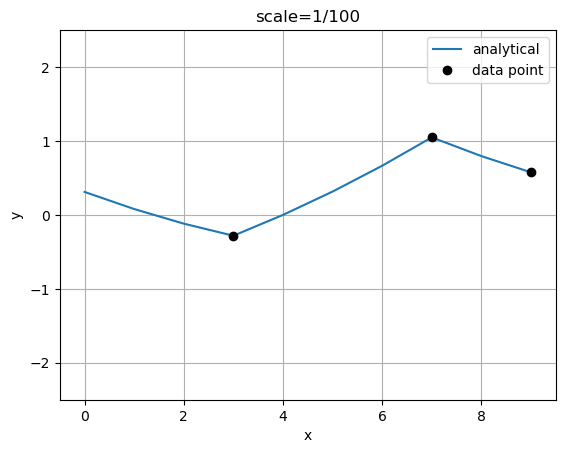

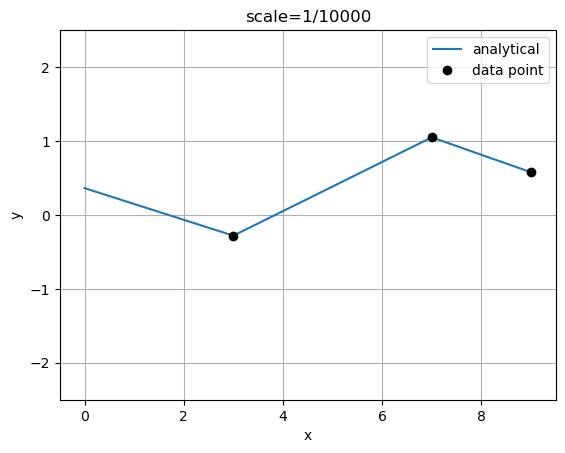

In [152]:
#j = 0
for idx_, vu in enumerate(vu_list):
    input_tensor = all_points[31,:]
    #ind = int(f'{num_points}{j}')
    y = input_tensor[:10]
    mask = input_tensor[10:]
    mask_bool = mask > 0.5
    points = torch.where(mask_bool)[0]
    values = y[mask_bool]

    #test_obs = test_obses[ind]
    #out = model(test_obs)

    plt.figure()
    #plt.title(f'analytical, {num_points} data points')
    #if num_points == 1:
    #    plt.title(f'analytical, {num_points} data point')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(range(10), sol[idx_])
    plt.plot(points, values, 'ko')
    #plt.plot(range(10), out.detach().numpy())
    plt.legend(['analytical', 'data point'])
    #plt.legend(['data points', 'analytical', 'ML-inf'])
    plt.grid()
    plt.title(f'scale=1/{vu}')
    plt.axis([-0.5, 9.5, -2.5, 2.5])
    plt.savefig(f'../figures/plot_inversion/inversion_scaled_{vu}.png')